In [2]:

# user engagement analysis

%reload_ext autoreload
%autoreload 2

In [15]:
print('this is a user engagement analysis')

this is a user engagement analysis


In [3]:
# importing liberaries 
import missingno as msno 
import matplotlib.pyplot as plt 
import pandas as pd
from sqlalchemy import create_engine
import sys 
import os 
import numpy as np 
import seaborn as sns 
import sys, os
import sklearn
from sklearn.decomposition import PCA
import logging
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
df_cleaned = pd.read_csv('/home/hp/10academy/10telecom/useranalyst.csv')

In [5]:
df_cleaned.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes),Total_Session_duration,Decile_Class
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0,2083209.0,4
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0,1698167.0,4
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0,1361762.0,4
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0,1321509.0,4
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0,1089009.0,4


In [6]:
df_cleaned.columns

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name',
       'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'Activity Duration DL (ms)', 'Activity Duration UL (ms)', 'Dur. (ms).1',
       'Handset Manufacturer', 'Handset Type', 'Nb of sec with Vol DL < 6250B',
       'Nb of sec with Vol UL < 1250B', 'Social Media DL (Bytes)',
       'Social Media UL (Bytes)', 'Google DL (Bytes)', 'Google UL (Bytes)',
       'Email DL (Bytes)', 'Email UL (Bytes)', 'Youtube DL (Bytes)',
       'Youtube UL (Bytes)', 'Netflix DL (Bytes)', 'Netflix UL (Bytes)',
       'Gaming DL (Bytes)', 'Gaming UL (Bytes)', 'Other DL (Bytes)',
       'Other UL (Bytes)', 'Total UL (

In [7]:
current_directory = os.getcwd()
parent_directory = os.path.abspath(os.path.join(current_directory, '..'))

if parent_directory not in sys.path:
    sys.path.insert(0, parent_directory)


from src.utils import percent_missing, format_float, find_agg, missing_values_table,convert_bytes_to_megabytes,fix_missing_ffill,fix_missing_bfill


database_name = 'tcom'
table_name= 'xdr_data'

connection_params = { "host": "localhost", "user": "postgres", "password": "1234",
                    "port": "5432", "database": database_name}

engine = create_engine(f"postgresql+psycopg2://{connection_params['user']}:{connection_params['password']}@{connection_params['host']}:{connection_params['port']}/{connection_params['database']}")

# str or SQLAlchemy Selectable (select or text object)
sql_query = 'SELECT * FROM xdr_data'

df = pd.read_sql(sql_query, con= engine)

In [8]:
print(df.columns)

Index(['Bearer Id', 'Start', 'Start ms', 'End', 'End ms', 'Dur. (ms)', 'IMSI',
       'MSISDN/Number', 'IMEI', 'Last Location Name', 'Avg RTT DL (ms)',
       'Avg RTT UL (ms)', 'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)',
       'TCP DL Retrans. Vol (Bytes)', 'TCP UL Retrans. Vol (Bytes)',
       'DL TP < 50 Kbps (%)', '50 Kbps < DL TP < 250 Kbps (%)',
       '250 Kbps < DL TP < 1 Mbps (%)', 'DL TP > 1 Mbps (%)',
       'UL TP < 10 Kbps (%)', '10 Kbps < UL TP < 50 Kbps (%)',
       '50 Kbps < UL TP < 300 Kbps (%)', 'UL TP > 300 Kbps (%)',
       'HTTP DL (Bytes)', 'HTTP UL (Bytes)', 'Activity Duration DL (ms)',
       'Activity Duration UL (ms)', 'Dur. (ms).1', 'Handset Manufacturer',
       'Handset Type', 'Nb of sec with 125000B < Vol DL',
       'Nb of sec with 1250B < Vol UL < 6250B',
       'Nb of sec with 31250B < Vol DL < 125000B',
       'Nb of sec with 37500B < Vol UL',
       'Nb of sec with 6250B < Vol DL < 31250B',
       'Nb of sec with 6250B < Vol UL < 37500B',


In [9]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load your dataset (replace this with your actual dataset loading)
# Example:
# df = pd.read_csv('your_dataset.csv')

# Task 4.1 - Aggregate, per customer, the required information

# Replace missing values with mean/mode for respective columns
df['TCP UL Retrans. Vol (Bytes)'].fillna(df['TCP UL Retrans. Vol (Bytes)'].mean(), inplace=True)
df['TCP DL Retrans. Vol (Bytes)'].fillna(df['TCP DL Retrans. Vol (Bytes)'].mean(), inplace=True)
df['Avg RTT DL (ms)'].fillna(df['Avg RTT DL (ms)'].mean(), inplace=True)
df['Avg RTT UL (ms)'].fillna(df['Avg RTT UL (ms)'].mean(), inplace=True)
df['Handset Type'].fillna(df['Handset Type'].mode()[0], inplace=True)
df['Avg Bearer TP UL (kbps)'].fillna(df['Avg Bearer TP UL (kbps)'].mean(), inplace=True)
df['Avg Bearer TP DL (kbps)'].fillna(df['Avg Bearer TP DL (kbps)'].mean(), inplace=True)

# Aggregate the required information per customer
aggregated_info = df.groupby('MSISDN/Number').agg ({
    'TCP UL Retrans. Vol (Bytes)': 'mean',
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Avg RTT UL (ms)': 'mean',
    'Handset Type': lambda x: x.mode()[0],
    'Avg Bearer TP DL (kbps)': 'mean',
    'Avg Bearer TP UL (kbps)': 'mean'
}).reset_index()

aggregated_info


,MSISDN/Number,TCP UL Retrans. Vol (Bytes),TCP DL Retrans. Vol (Bytes),Avg RTT DL (ms),Avg RTT UL (ms),Handset Type,Avg Bearer TP DL (kbps),Avg Bearer TP UL (kbps)
0,3.360100e+10,759658.664811,2.080991e+07,46.000000,0.000000,Huawei P20 Lite Huawei Nova 3E,37.0,39.0
1,3.360100e+10,759658.664811,2.080991e+07,30.000000,1.000000,Apple iPhone 7 (A1778),48.0,51.0
2,3.360100e+10,759658.664811,2.080991e+07,109.795706,17.662883,undefined,48.0,49.0
3,3.360101e+10,759658.664811,1.066000e+03,69.000000,15.000000,Apple iPhone 5S (A1457),204.0,44.0
4,3.360101e+10,390430.332406,1.507977e+07,57.000000,2.500000,Apple iPhone Se (A1723),20197.5,8224.5
...,...,...,...,...,...,...,...,...
106851,3.379000e+10,3001.000000,2.150440e+05,42.000000,10.000000,Huawei Honor 9 Lite,9978.0,387.0
106852,3.379000e+10,759658.664811,2.080991e+07,34.000000,6.000000,Apple iPhone 8 Plus (A1897),68.0,48.0
106853,3.197021e+12,759658.664811,2.080991e+07,109.795706,17.662883,Quectel Wireless. Quectel Ec25-E,1.0,0.0
106854,3.370000e+14,759658.664811,2.080991e+07,109.795706,17.662883,Huawei B525S-23A,11.0,22.0


In [10]:

    
    
# Task 4.2 - Compute & list 10 of the top, bottom and most frequent values
top_10_tcp = df['TCP UL Retrans. Vol (Bytes)'].nlargest(10)
bottom_10_tcp = df['TCP UL Retrans. Vol (Bytes)'].nsmallest(10)
most_frequent_tcp = df['TCP UL Retrans. Vol (Bytes)'].value_counts().head(10)

listoftcp=[top_10_tcp,bottom_10_tcp,most_frequent_tcp]
print(listoftcp)

top_10_rtt = df['Avg RTT UL (ms)'].nlargest(10)
bottom_10_rtt = df['Avg RTT UL (ms)'].nsmallest(10)
most_frequent_rtt = df['Avg RTT UL (ms)'].value_counts().head(10)
listofrtt=[top_10_rtt,bottom_10_rtt,most_frequent_rtt]
print(listofrtt)

top_10_throughput = df['Avg Bearer TP UL (kbps)'].nlargest(10)
bottom_10_throughput = df['Avg Bearer TP UL (kbps)'].nsmallest(10)
most_frequent_throughput = df['Avg Bearer TP UL (kbps)'].value_counts().head(10)
listofthroughput=[top_10_throughput,bottom_10_throughput,most_frequent_throughput]
print(listofthroughput)



[36203     2.908226e+09
76644     2.636857e+09
67308     2.455600e+09
1505      2.260359e+09
133264    1.751384e+09
35138     1.727810e+09
142220    1.237862e+09
142432    7.948258e+08
66072     7.195718e+08
1381      5.262463e+08
Name: TCP UL Retrans. Vol (Bytes), dtype: float64, 13275     1.0
15253     1.0
36086     1.0
38407     1.0
75089     1.0
78706     1.0
90224     1.0
124050    1.0
138837    1.0
139021    1.0
Name: TCP UL Retrans. Vol (Bytes), dtype: float64, TCP UL Retrans. Vol (Bytes)
759658.664811    96649
1330.000000       1910
2660.000000        937
1294.000000        651
3990.000000        548
1318.000000        545
5320.000000        366
6650.000000        271
2636.000000        234
7980.000000        219
Name: count, dtype: int64]
[20027     7120.0
132557    5607.0
85023     5422.0
184       5279.0
95354     4677.0
42107     4226.0
49599     4021.0
137955    3923.0
124792    3093.0
46001     3029.0
Name: Avg RTT UL (ms), dtype: float64, 54     0.0
99     0.0
176    0.0

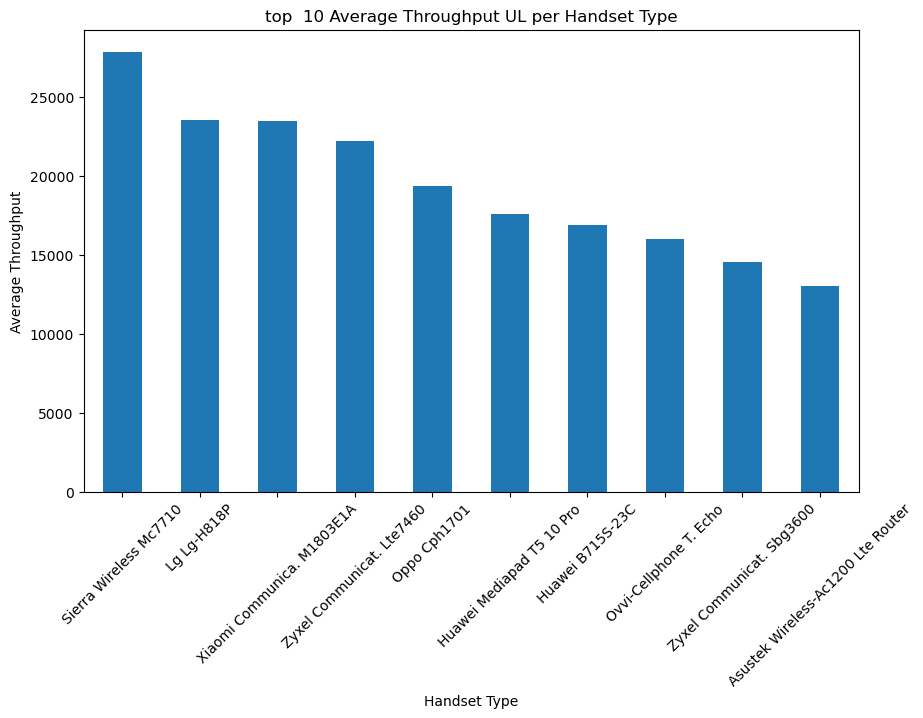

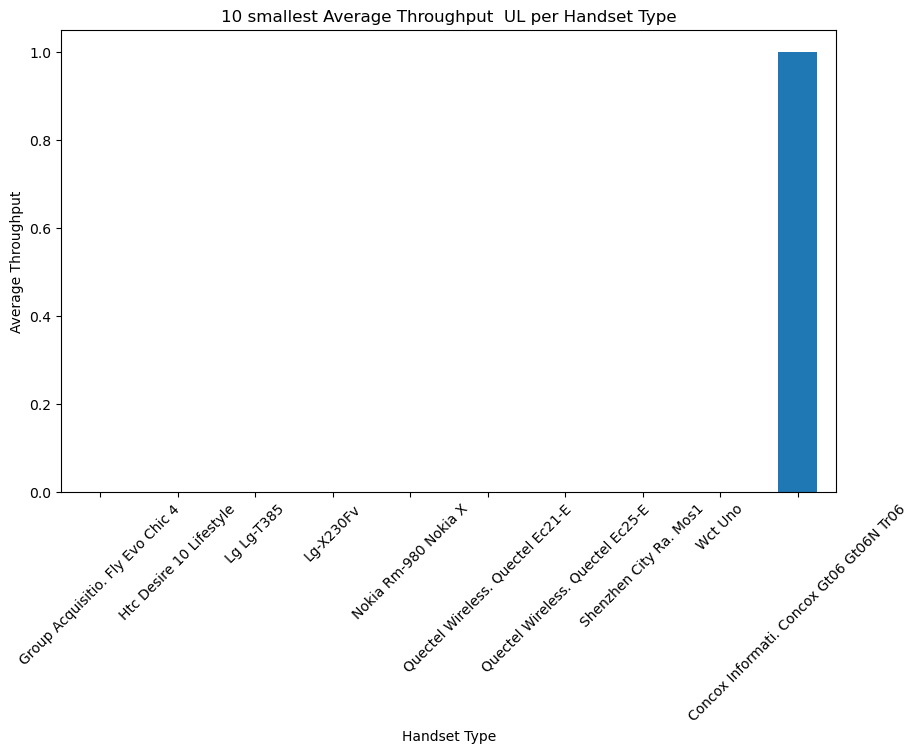

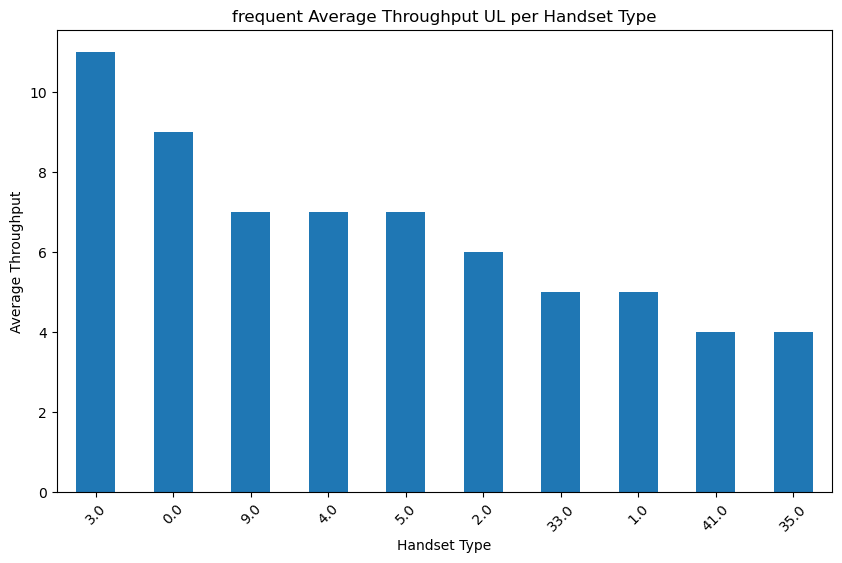

In [11]:
# Task 4.3 - Compute & report the distribution of average throughput per handset type
df['Avg Bearer TP UL (kbps)'] = pd.to_numeric(df['Avg Bearer TP UL (kbps)'], errors='coerce')

avg_throughput_per_handset = df.groupby('Handset Type')['Avg Bearer TP UL (kbps)'].mean().nlargest(10)
avg_throughput_per_handset1 = df.groupby('Handset Type')['Avg Bearer TP UL (kbps)'].mean().nsmallest(10)
avg_throughput_per_handset2 = df.groupby('Handset Type')['Avg Bearer TP UL (kbps)'].mean().value_counts().head(10)
# Plotting the distribution of average throughput per Handset Type
plt.figure(figsize=(10, 6))
avg_throughput_per_handset.plot(kind='bar')
plt.title('top  10 Average Throughput UL per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput')
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(10, 6))
avg_throughput_per_handset1.plot(kind='bar')
plt.title('10 smallest Average Throughput  UL per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput')
plt.xticks(rotation=45)
plt.show()
plt.figure(figsize=(10, 6))
avg_throughput_per_handset2.plot(kind='bar')
plt.title('frequent Average Throughput UL per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput')
plt.xticks(rotation=45)
plt.show()
# Task 4.3 - Compute & report the distribution of average throughput per handset type



/home/hp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/hp/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

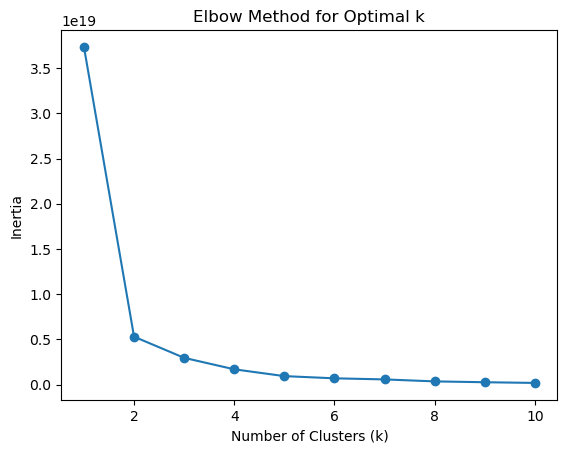

In [14]:
# Task 4.4 - Perform k-means clustering (k=3) on experience metrics
experience_metrics = df[['TCP UL Retrans. Vol (Bytes)', 'Avg RTT UL (ms)', 'Avg Bearer TP UL (kbps)']]
# Elbow method to find optimized k value
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(experience_metrics)
    inertia_values.append(kmeans.inertia_)

# Plot inertia values for different k values
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

